# Dati Covid-19

In [5]:
import sys, glob
import pandas as pd
import numpy as np
from miscellanea import adatta_nome, importa_abitanti, importa_dati_giornalieri, date_mancanti
from miscellanea import importa_dati_italia, importa_dati_emr, importa_dati_prov

### Dati nazionali, regionali, provinciali

Fonte dati: [Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile](https://github.com/pcm-dpc)

Import dati nazionali e regionali

In [6]:
dataset = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
ita = importa_dati_italia(dataset)
ita_abitanti = 59_641_488 # Fonte https://www.tuttitalia.it/regioni/popolazione/

emr = importa_dati_emr(dataset)
emr_abitanti = 4_464_119 # Fonte https://www.tuttitalia.it/regioni/popolazione/

Import dati provinciali

In [7]:
dataset = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'

mo = importa_dati_prov(dataset)
mo_abitanti = 707_119 # Fonte https://www.tuttitalia.it/emilia-romagna/provincia-di-modena/

### Dati provincia di Modena - dettaglio comune per comune

Fonte: nuovi positivi comune per comune dal report dell'AUSL di Modena (letti sulle pagine di [sulpanaro.net](https://www.sulpanaro.net/)).

I dati vegono importati da `salva_report.py` e salvati nella cartella report_vari: 

In [8]:
dfcomuni = pd.read_csv('report_vari/nuovi_positivi_comuni_MO.csv', index_col=0, parse_dates=True)

Abitanti dei comuni nella provincia di Modena da [qui](https://www.tuttitalia.it/emilia-romagna/provincia-di-modena/70-comuni/popolazione/) (aggiornato a 31/12/2019 - dati ISTAT)

In [9]:
abitanti = importa_abitanti('abitanti_provincia_di_Modena.txt')

Aggiungi al dizionario `abitanti` quelli di provincia, regione, nazione

In [10]:
abitanti['Emilia Romagna'] = emr_abitanti
abitanti['Italia'] = ita_abitanti
abitanti['Provincia MO'] = mo_abitanti

Crea le varie timeline di incidenza 7gg.

In [11]:
roll = dfcomuni.rolling(7, center=False).sum()
ita_roll = ita.rolling(7, center=False).sum()
emr_roll = emr.rolling(7, center=False).sum()
mo_roll = mo.rolling(7, center=False).sum()

## Grafici

### Nonantola

Lista comuni di confronto (tutti quelli con > 10mila abitanti)

In [12]:
lista_comuni = [ k for k,v in abitanti.items() if (v>10000) & (k not in ['Emilia Romagna', 'Provincia MO', 'Italia', 'Nonantola']) ]

In [20]:
range_temporale = '2021-03-15'

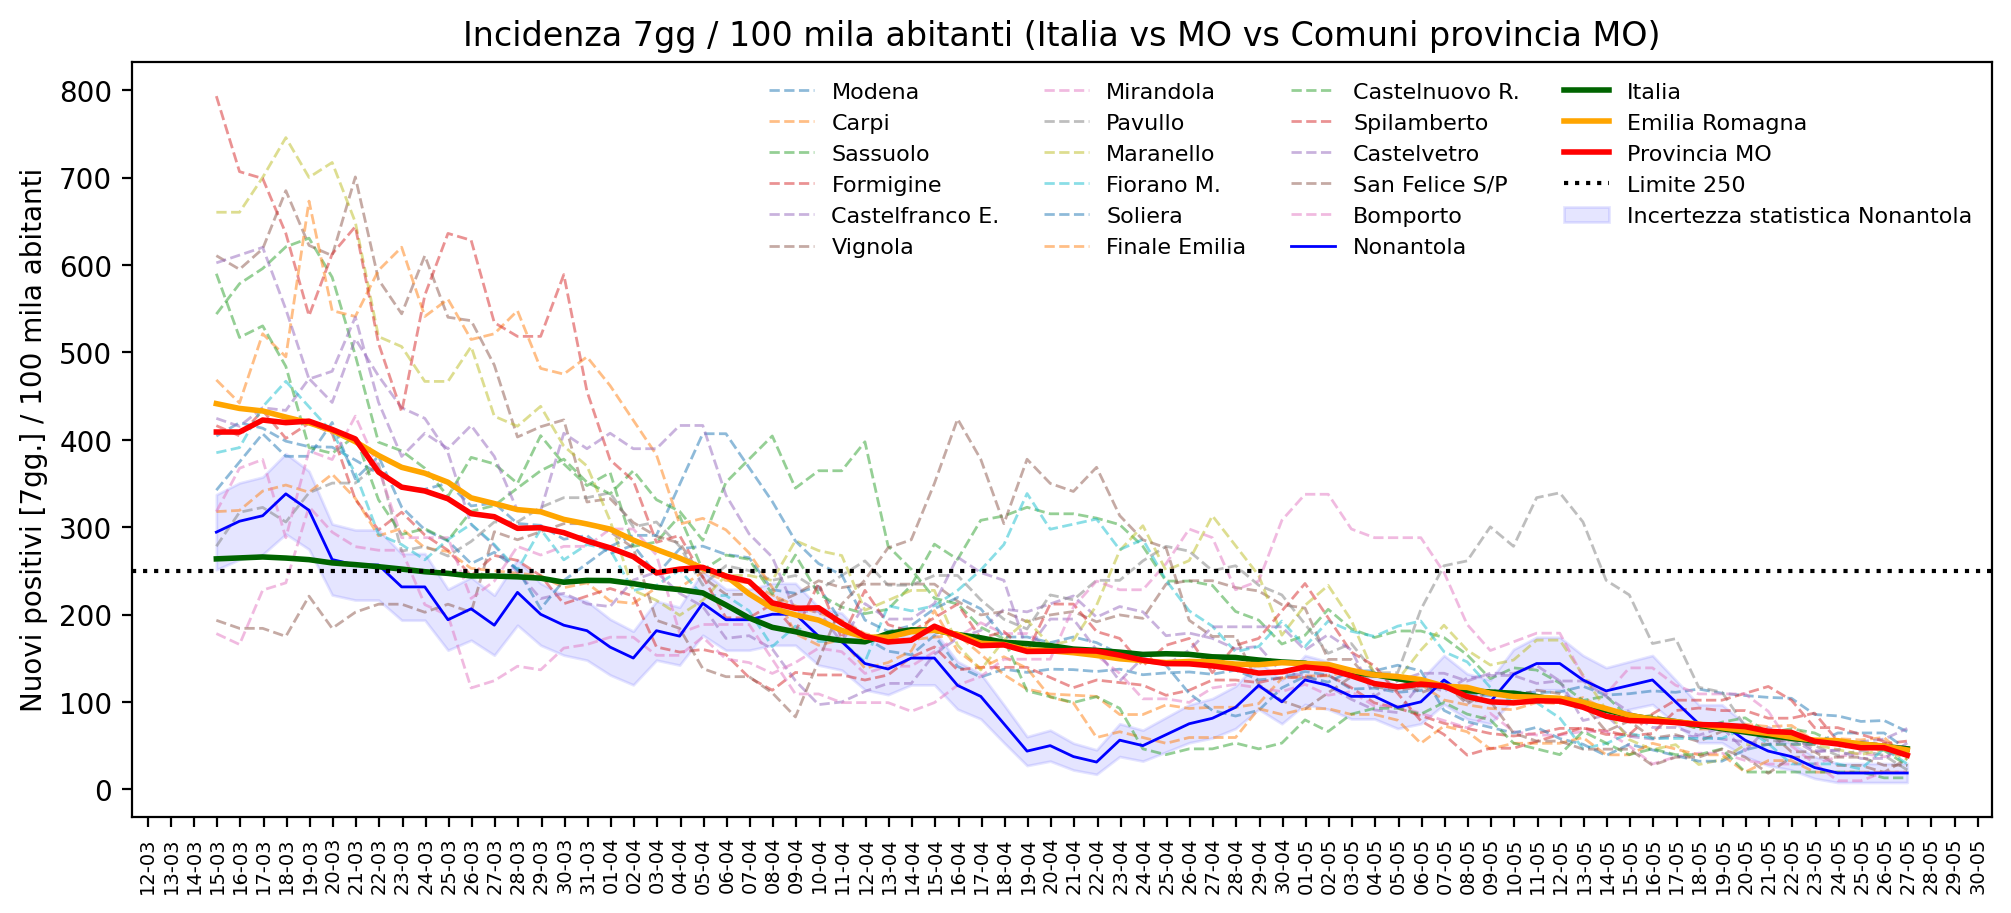

In [21]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

#plt.style.use('dark_background')
plt.style.use('fast')
# plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-deep')
# plt.style.use('seaborn-dark-palette')

fig, ax = plt.subplots(figsize=(12,5), dpi=200)

xfmt = mdates.DateFormatter('%d-%m')
xloc = mdates.HourLocator(interval=24)
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.set_major_locator(xloc)
ax.tick_params(axis='x', rotation=90, labelsize=7)
# ax.tick.label.set_fontsize('x-small')

ax.set_title('Incidenza 7gg / 100 mila abitanti (Italia vs MO vs Comuni provincia MO)')
ax.set_ylabel('Nuovi positivi [7gg.] / 100 mila abitanti')

for k in lista_comuni:
    toplot = roll[k]/abitanti[k]*100000
    ax.plot(toplot[range_temporale:], 
            linestyle='--',
#              drawstyle='steps',
            alpha=0.5, lw=1, label=k
           )
    
# Nonantola
toplot = roll['Nonantola']/abitanti['Nonantola']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=1, color='blue', label='Nonantola')

# # Soliera
# toplot = roll['Soliera']/abitanti['Soliera']*100000
# ax.plot(toplot[range_temporale:], alpha=1, lw=3, color='Magenta', label='Soliera')

# Nonantola, banda incert. statistica    
toplot_inf = (roll['Nonantola'] - np.sqrt(roll['Nonantola'])) / abitanti['Nonantola']*100000
toplot_sup = (roll['Nonantola'] + np.sqrt(roll['Nonantola'])) / abitanti['Nonantola']*100000
ax.fill_between(toplot_inf[range_temporale:].index, 
                toplot_sup[range_temporale:],
                toplot_inf[range_temporale:],
                alpha=0.1, color='blue',
               label='Incertezza statistica Nonantola')

## Nazione, Regione, Provincia
toplot = ita_roll/abitanti['Italia']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=2, color='darkgreen', label='Italia')
toplot = emr_roll/abitanti['Emilia Romagna']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=2, color='orange', label='Emilia Romagna')
toplot = mo_roll/abitanti['Provincia MO']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=2, color='red', label='Provincia MO')

# linea 250
ax.axhline(250, linestyle=':', c='k', label='Limite 250')

plt.legend(ncol=4, fontsize=8, frameon=False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=8)

plt.show()
fig.set_facecolor('white')
fig.savefig('Nonantola.png')
fig.savefig('Nonantola.pdf')

Dettaglio di un dato giorno

In [19]:
giorno='2021-05-27'
titolo = pd.to_datetime(giorno)

dettaglio={}
for k in lista_comuni:
    toplot = roll[k]/abitanti[k]*100000
    dettaglio[k] = toplot[giorno]

# highlight colorato Nonantola
# "\x1b[46m\"cyan bkg\"\x1b[0m"
openingseq = {c:'\x1b[0m' for c in lista_comuni}
closiningseq = '\x1b[0m'
openingseq['Nonantola'] = '\x1b[1;46m'

ultimo = [(k,v) for k,v in dettaglio.items()]
ultimo.append(('Nonantola', (roll['Nonantola']/abitanti['Nonantola']*100000)[giorno]))
ultimo.sort(key=lambda x:x[1])
print(f"# Giorno: \x1b[46m{titolo:%d-%m-%Y}\x1b[0m")
sottotitolo='# nr, comune, incid7gg/100mila ab.'
print(sottotitolo)
print('-'*len(sottotitolo))
for i,e in enumerate(ultimo[::-1]):
    print(f'{openingseq[e[0]]}{i+1}\t{e[0]:20}{e[1]:.1f}{closiningseq}')

# Giorno: 27-05-2021
# nr, comune, incid7gg/100mila ab.
----------------------------------
1	Castelfranco E.     69.7
2	Modena              66.1
3	Formigine           55.3
4	Castelvetro         53.1
5	Soliera             45.2
6	Mirandola           41.5
7	Spilamberto         39.3
8	Carpi               35.9
9	Vignola             35.2
10	Maranello           34.2
11	Fiorano M.          29.2
12	San Felice S/P      27.6
13	Sassuolo            27.3
14	Pavullo             22.2
15	Bomporto            19.9
16	Finale Emilia       19.8
17	Nonantola           18.8
18	Castelnuovo R.      13.3


In [12]:
emr_roll/abitanti['Emilia Romagna']*100000, mo_roll/abitanti['Provincia MO']*100000

(data
 2020-02-24           NaN
 2020-02-25           NaN
 2020-02-26           NaN
 2020-02-27           NaN
 2020-02-28           NaN
                  ...    
 2021-04-04    264.688285
 2021-04-05    253.084651
 2021-04-06    244.213920
 2021-04-07    223.739555
 2021-04-08    207.297341
 Length: 410, dtype: float64, data
 2020-02-24           NaN
 2020-02-25           NaN
 2020-02-26           NaN
 2020-02-27           NaN
 2020-02-28           NaN
                  ...    
 2021-04-04    252.008502
 2021-04-05    253.988367
 2021-04-06    243.947624
 2021-04-07    237.866611
 2021-04-08    213.401139
 Length: 410, dtype: float64)

## Superamenti 250/100mila

Comuni fra 10mila e 20mila abitanti

Attraversamenti soglia 250/100mila

In [12]:
cross = {} # dict con serie dei crossing points
for c in lista_comuni:
    s = roll[c]/abitanti[c]*100_000
    crossings = (s>250) & (s.shift(1)<250) 
    cross[c] = s[crossings][range_temporale:]

Elenco superamenti

In [13]:
for c in lista_comuni:
    print('-'*40)
    print(f'Comune: {c} (ab. {abitanti[c]})')
    print(f'Superamenti: {len(cross[c])}')
    print('-'*40)
    for el in cross[c].iteritems():
        print(f'\t{el[0].date()}: {el[1]:.1f}')
   

----------------------------------------
Comune: Modena (ab. 189013)
Superamenti: 6
----------------------------------------
	2020-10-29: 270.4
	2020-12-25: 252.4
	2020-12-30: 255.0
	2021-01-02: 259.2
	2021-02-11: 254.0
	2021-02-26: 266.6
----------------------------------------
Comune: Carpi (ab. 72369)
Superamenti: 5
----------------------------------------
	2020-11-01: 294.3
	2020-12-18: 258.4
	2021-01-07: 269.5
	2021-01-20: 251.5
	2021-02-27: 250.1
----------------------------------------
Comune: Sassuolo (ab. 40278)
Superamenti: 5
----------------------------------------
	2020-11-01: 315.3
	2020-12-16: 268.1
	2020-12-31: 255.7
	2021-01-17: 250.8
	2021-02-23: 273.1
----------------------------------------
Comune: Formigine (ab. 34366)
Superamenti: 8
----------------------------------------
	2020-10-31: 253.2
	2020-11-02: 250.2
	2020-12-03: 276.4
	2020-12-19: 250.2
	2020-12-23: 264.8
	2021-01-01: 308.4
	2021-01-15: 308.4
	2021-02-23: 273.5
----------------------------------------
Co